In [71]:
import pandas as pd
hist_data = pd.read_csv('C:/Users/danbi/Desktop/final_hist_data.csv')
hist_data['Result'] = hist_data['Result'].map({'W':1, 'L':0})
hist_data

,Rate,Def Passer Rate,Def Rush Att,Rush Att,TD allowed,Def Cmp%,3D%,Def Sack Yds,TO,Sk Yds,...,Yards After Contacts,IAY,Pressured,Rush Yds,BadTh,YAC,Rush 1st Allowed,Seasonweek,Result,Team
0,0.861510,-1.205811,-1.189206,-0.267598,-1.022158,0.624982,3.629110,2.520229,2.349470,-0.879836,...,-0.368759,-0.314909,-1.459041,0.057891,-0.799056,0.282068,-1.151653,20221,1,BUF
1,-1.102407,0.906857,-0.267598,-1.189206,1.094890,2.021750,0.523400,-0.879836,1.482644,2.520229,...,-1.147692,-0.179990,1.760817,-1.277688,0.697596,-0.453427,0.103576,20221,0,RAM
2,0.166709,2.213375,-0.004281,-0.662573,2.506256,1.281039,-0.979821,-1.266207,-1.117833,0.742923,...,0.187622,0.134823,4.732994,-0.290521,-0.424893,-0.150576,0.103576,20221,0,CRD
3,-0.435720,0.724183,-1.057548,1.443961,0.389208,0.296953,-0.022581,1.438391,0.615818,-1.266207,...,0.187622,0.303473,-1.211360,1.606388,1.071759,-0.388531,-0.524039,20221,0,ATL
4,0.311292,-0.578365,-1.320864,-0.794231,-1.022158,-0.221544,-0.022581,-0.338916,-0.251007,-1.111658,...,-1.518612,1.180452,-0.963678,-1.064770,0.697596,-0.691382,-1.151653,20221,1,RAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,1.897687,0.279410,-0.794231,-0.399256,-0.316475,0.117066,1.111925,-0.107094,-1.117833,-0.261642,...,-0.591311,-0.449829,-0.715997,0.154672,-1.173219,0.325333,-1.151653,202418,1,SEA
1626,-0.182700,1.589900,-0.004281,0.127377,2.506256,0.699053,-0.022581,-1.266207,1.482644,0.897471,...,0.521451,0.831909,0.274729,0.386946,1.071759,-0.583221,0.417383,202418,0,SFO
1627,0.114498,-0.169333,-1.057548,0.522352,-1.022158,-0.306197,1.679177,-0.338916,-0.251007,-0.879836,...,-0.109114,0.033633,-0.715997,1.180551,-0.424893,-1.318717,-0.837846,202418,1,TAM
1628,0.596441,0.156304,0.259036,0.654011,0.389208,-0.052239,-0.391296,-0.416190,-0.251007,-0.029819,...,-0.850955,0.494609,-0.715997,-0.638933,-0.424893,-0.410163,0.417383,202418,0,OTI


In [72]:
hist_data['Seasonweek'] = hist_data['Seasonweek'].astype(str).apply(lambda x: x[:4] + x[4:].zfill(2)).astype(int)

In [73]:
top_20 = ['Rate', 'Def Passer Rate', 'Def Rush Att', 'Rush Att', 'TD allowed', 'Def Cmp%', '3D%',
          'Def Sack Yds', 'TO', 'Sk Yds', '1stD', 'Opp3D%', 'Def Prss', 'Yards After Contacts', 'IAY',
          'Pressured', 'Rush Yds', 'BadTh', 'YAC', 'Rush 1st Allowed']

In [74]:
all_weeks = sorted(hist_data['Seasonweek'].unique())

In [75]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_gru_model_for_embeddings(input_shape=(17, 20)):
    model = Sequential()
    model.add(Input(shape=input_shape))  # (timesteps, features)
    model.add(GRU(64, return_sequences=False))   # Embedding comes from here or next layer
    model.add(Dense(32, activation='relu'))      # Optional transformation layer
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))    # Final prediction

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [76]:
def get_embedding_model(gru_model):
    # Extract the output of the Dense embedding layer (assumed second last layer)
    embedding_layer = gru_model.layers[-3]
    embedding_model = Model(inputs=gru_model.input, outputs=embedding_layer.output)
    return embedding_model

In [77]:
import numpy as np

def prepare_gru_input(hist_data, top_20):
    # This depends on your data shape; here is a simple example assuming 1 timestep:
    X = hist_data[top_20].values.astype(np.float32)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # samples, timesteps=1, features
    y = hist_data['Result'].values.astype(np.float32)
    return X, y

In [78]:
team_embeddings_by_week = {}
weekly_metrics = {}

for i, current_week in enumerate(all_weeks):
    if i == 0:
        print(f"Skipping week {current_week} (no prior data for training).")
        continue

    # Split data
    train_df = hist_data[hist_data['Seasonweek'] < current_week]
    test_df = hist_data[hist_data['Seasonweek'] == current_week]
    
    X_train, y_train = prepare_gru_input(train_df, top_20)
    X_test, y_test = prepare_gru_input(test_df, top_20)

    input_shape = (X_train.shape[1], X_train.shape[2])
    gru_model = build_gru_model(input_shape)

    # Train
    history = gru_model.fit(X_train, y_train, epochs=10, validation_split=0.1, verbose=1)

    weekly_metrics[current_week] = history.history

    # Get embedding model
    embedding_model = get_embedding_model(gru_model)

    # Generate embeddings for test teams
    test_teams = test_df['Team'].values
    embeddings = embedding_model.predict(X_test)

    # Store embeddings by team and week
    for team, emb in zip(test_teams, embeddings):
        team_embeddings_by_week.setdefault(team, {})[current_week] = emb

    print(f"Week {current_week} embeddings generated for {len(test_teams)} teams.")


Skipping week 202201 (no prior data for training).
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5357 - loss: 0.7077 - val_accuracy: 0.5000 - val_loss: 0.7543
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5000 - loss: 0.7091 - val_accuracy: 0.5000 - val_loss: 0.7541
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5000 - loss: 0.7009 - val_accuracy: 0.5000 - val_loss: 0.7539
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5000 - loss: 0.6713 - val_accuracy: 0.5000 - val_loss: 0.7536
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5357 - loss: 0.6486 - val_accuracy: 0.5000 - val_loss: 0.7534
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - loss: 0.6865 - val_accuracy: 0.5000 - val_loss: 0.7531
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5000 - loss: 0.6794 - val_accuracy: 0.5000 - val_loss: 0.7529
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5000 - loss: 

In [79]:
embedding = team_embeddings_by_week.get('GNB', {}).get(202318)
if embedding is not None:
    print(f"GNB embedding for 202318: {embedding}")
else:
    print("Embedding not found.")

GNB embedding for 202318: [0.         0.5988507  0.20940496 0.         0.03553753 1.1218593
 0.         0.46435198 0.8460657  0.1820843  0.         0.
 0.         0.         0.         0.        ]


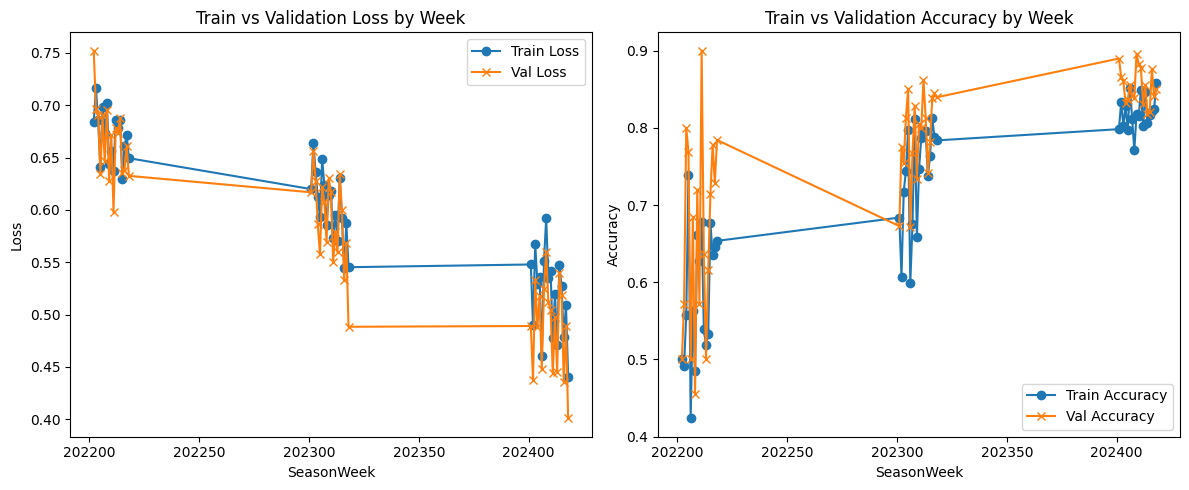

In [80]:
import matplotlib.pyplot as plt

weeks = sorted(weekly_metrics.keys())
train_losses = [weekly_metrics[w]['loss'][-1] for w in weeks]
val_losses = [weekly_metrics[w]['val_loss'][-1] for w in weeks]
train_accs = [weekly_metrics[w].get('accuracy', [None])[-1] for w in weeks]
val_accs = [weekly_metrics[w].get('val_accuracy', [None])[-1] for w in weeks]

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(weeks, train_losses, label='Train Loss', marker='o')
plt.plot(weeks, val_losses, label='Val Loss', marker='x')
plt.xlabel("SeasonWeek")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss by Week")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(weeks, train_accs, label='Train Accuracy', marker='o')
plt.plot(weeks, val_accs, label='Val Accuracy', marker='x')
plt.xlabel("SeasonWeek")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy by Week")
plt.legend()

plt.tight_layout()
plt.show()


In [81]:
# converting embeddings to flat dataframe
import pandas as pd

def flatten_embeddings(embeddings_dict):
    records = []
    for team, weeks in embeddings_dict.items():
        for seasonweek, emb in weeks.items():
            row = {'team': team, 'seasonweek': seasonweek}
            row.update({f'emb_{i}': val for i, val in enumerate(emb)})
            records.append(row)
    return pd.DataFrame(records)

df_embeddings = flatten_embeddings(team_embeddings_by_week)
df_embeddings.to_csv("gru_team_embeddings_by_week.csv", index=False)

In [82]:
model.save('gru_model.keras')